In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import norm
import datetime
from pandasql import sqldf
import seaborn as sns
sns.set(style="darkgrid")

## 1. Overviews

### 1.1 Tables
#### 1.1.1 yammer_users

In [2]:
users = pd.read_csv('yammer_users.csv')
users.head()

,user_id,created_at,company_id,language,activated_at,state
0,0.0,2013-01-01 20:59:39,5737.0,english,2013-01-01 21:01:07,active
1,1.0,2013-01-01 13:07:46,28.0,english,NaN,pending
2,2.0,2013-01-01 10:59:05,51.0,english,NaN,pending
3,3.0,2013-01-01 18:40:36,2800.0,german,2013-01-01 18:42:02,active
4,4.0,2013-01-01 14:37:51,5110.0,indian,2013-01-01 14:39:05,active


#### 1.1.2 yammer_experiments
Inside this table, the `experiment_group` column indicates which record belongs to control group while which one is experimental group.

In [3]:
experiments = pd.read_csv('yammer_experiments.csv')
experiments.head()

,user_id,occurred_at,experiment,experiment_group,location,device,user_type
0,4.0,2014-06-05 15:20:16,publisher_update,control_group,India,lenovo thinkpad,3.0
1,8198.0,2014-06-11 09:31:32,publisher_update,control_group,Japan,nokia lumia 635,1.0
2,11.0,2014-06-17 09:31:22,publisher_update,control_group,United States,iphone 4s,1.0
3,8209.0,2014-06-04 09:31:21,publisher_update,test_group,Turkey,nokia lumia 635,1.0
4,19.0,2014-06-04 09:31:33,publisher_update,test_group,Nigeria,iphone 5,1.0


#### 1.1.3 yammer_events

In [4]:
events = pd.DataFrame()
for i in range(1, 4):
    df = pd.read_csv('yammer_events%d.csv' % i)
    events = pd.concat([events, df], ignore_index = True)

events.head()

,user_id,occurred_at,event_type,event_name,location,device,user_type
0,10522.0,2014-05-02 11:02:39,engagement,login,Japan,dell inspiron notebook,3.0
1,10522.0,2014-05-02 11:02:53,engagement,home_page,Japan,dell inspiron notebook,3.0
2,10522.0,2014-05-02 11:03:28,engagement,like_message,Japan,dell inspiron notebook,3.0
3,10522.0,2014-05-02 11:04:09,engagement,view_inbox,Japan,dell inspiron notebook,3.0
4,10522.0,2014-05-02 11:03:16,engagement,search_run,Japan,dell inspiron notebook,3.0


### 1.2 Problem Description

Like many software companies, Yammer freqently tests these features before releasing them to all of their customers. A/B testing is an experimental method to help analysts and product managers better understand a feature's effect on user behavior and the overall user experience.

In this case, I focus on an improvement to Yammer's core 'publisher' - the module at the top of a Yammer feed where usrs type their messages. To test this feature, the product team ran an A/B test from June 1 to June 30, 2014. During this period, some users who logged into Yammer were shown the old version of the publisher (i.e. 'control group'), while other users were shown the new version (i.e. 'experiment/test group').

Things to be considerd on the test:
- Check to make sure that this test was run correctly. Is the query that calculates lift and p-value correct?
- Check other metrics to make sure that this outsized result is not isolated to this one metric. What other metrics are import? Do they show similar improvements?
- Check that the data is correct. Are there problems with the way the test results were recorded or the way users were treated into test and control groups? If something is incorrect, determine the steps necessary to correct the problem.
- Make the final recommendation based on your conclusions. Should the new publisher be rolled out to everone? Should it be re-tested? If so, what should be different? Should it be abandoned entirely?

## 2 Analysis

### 2.1 Preparation and prioritizing
Before digging around the test data, it's important to hypothesize how a feature might change user behavior, and why. If you identify changes in the data first, it can be very easy to rationalize why these changes should be obvious, even if you never would have have thought of them before the experiment.

- __Metrics__ : Average user logins, Average days of users' engagement, Average messages user sent

Similarly, it's important to develop hypotheses for explaining test results before looking further into the data. These hypotheses focus your thinking, provide specific conclusions to validate, and keep you from always concluding that the first potential answer you find is the right one.

- __Testing Hypothesis__ : Test of Equality of Two Means

*Recall for Hypothesis Testing*:

*Since we have two independent samples (experiment and control group) from two normal distributions (central limit theorm, when sample size is large enough, the sample distribution tends to follow normal distribution), also given known and unequal variances (we can calculated from samples) $\sigma_X^2 = \sigma_Y^2$, then:*

*The null hypothesis: $H_0 : \mu_x - \mu_y = 0$*

*The alternative hypothesis: $H_1 : \mu_x - \mu_y \neq 0$*

*The test statistic:*

$$ T = \frac{(\bar X - \bar Y)-(\mu_X - \mu_Y)}{\sqrt{\frac{S_X^2}{n} + \frac{S_Y^2}{m}}} $$

*and the adjusted degrees for freedom is determined by:*
$$df = \frac{(\frac{S_X^2}{n} + \frac{S_Y^2}{m})^2}{\frac{({S_X^2}/{ n})^2}{n-1} + \frac{({S_Y^2}/{m})^2}{m-1}}$$
*if $df$ doesn't equl to an interger, we then take the interger protion of it*.

### 2.2 Validating the results

In [5]:
# helper function that executes the sql query
pysqldf = lambda sql : sqldf(sql, globals())

#### 2.2.1 Identifying Metrics
The number of messages sent shouldn't be the only determinat of this test's success, so dig into a few other metrics to make sure that their outcomes were also positive. __In particular, we're interested in metrics that determine if a user is getting value out of Yammer.__ (Yammer typically uses login frequency as a core value metric.)

__Metric 1: Average logins__

First, let's check whether the number of users after running the experiment are significantly higher than before.
- __null hypothesis__ : the number of users after experiment is __the same as__ the number of users before.
- __alternative hypothesis__ : the number of users after experiment is __significantly diffferent from__ the number of users before.

In [6]:
sql = '''
WITH experiment AS (
    SELECT user_id, experiment, experiment_group, occurred_at
    FROM experiments
    WHERE experiment = 'publisher_update'
)
SELECT ex.experiment, ex.experiment_group, ex.occurred_at AS treatment_start,
       u.user_id, u.activated_at,
       COUNT(CASE WHEN e.event_name = 'login' THEN e.user_id ELSE NULL END) AS metric
FROM experiment ex
JOIN users u ON u.user_id = ex.user_id
JOIN events e ON e.user_id = ex.user_id
AND e.occurred_at >= ex.occurred_at
AND e.occurred_at < '2014-07-01'
AND e.event_type = 'engagement'
GROUP BY 1, 2, 3, 4, 5
'''
SQL = pysqldf(sql)
SQL.head()

,experiment,experiment_group,treatment_start,user_id,activated_at,metric
0,publisher_update,control_group,2014-06-01 01:02:31,597.0,2013-02-23 12:48:16,11
1,publisher_update,control_group,2014-06-01 04:16:34,13192.0,2014-05-28 04:15:19,5
2,publisher_update,control_group,2014-06-01 04:41:16,13184.0,2014-05-28 04:39:41,2
3,publisher_update,control_group,2014-06-01 06:26:50,3584.0,2013-08-28 16:45:31,4
4,publisher_update,control_group,2014-06-01 07:07:15,13088.0,2014-05-27 10:41:22,2


Sqlite does not provide standard deviation and variation calculation function. I found it really troublesom to do that on sqlite, thus I will use pandas to continue next step.

In [7]:
# 1. Calculating several statistics grouping by experiment and control groups
def CalStat(sql_df):
    cnt = sql_df[sql_df.experiment_group == 'control_group']
    exp = sql_df[sql_df.experiment_group == 'test_group']
    stat_df = pd.DataFrame({'experiment': ['publisher_update', 'publisher_update'],
                             'experiment_group': ['control_group', 'test_group']})
    stat_df['count'] = [len(cnt), len(exp)]
    stat_df['average'] = [cnt['metric'].mean(), exp['metric'].mean()]
    stat_df['sum'] = [sum(cnt.metric), sum(exp.metric)]
    stat_df['stdev'] = [cnt['metric'].std(), exp['metric'].std()]
    stat_df['variance'] = [cnt['metric'].var(), exp['metric'].var()]
    return stat_df


# 2. Significant test for two samples mean given two different variance
def HypothesisTest(stat_df):
    average_cnt, average_exp = stat_df['average'][0], stat_df['average'][1]
    variance_cnt, variance_exp = stat_df['variance'][0], stat_df['variance'][1]
    n_cnt, n_exp = stat_df['count'][0], stat_df['count'][1]

    t_stat = ((average_exp - average_cnt) - 0) / np.sqrt(variance_exp/n_exp + variance_cnt/n_cnt)
    degree_freedom = np.floor((variance_exp/n_exp + variance_cnt/n_cnt)**2 / ((variance_exp/n_exp)**2/(n_exp-1) + (variance_cnt/n_cnt)**2/(n_cnt-1)))
    p_value = stats.t.sf(t_stat, degree_freedom)*2
    print('T-statistic:', t_stat)
    print('Degrees of Freedom:', degree_freedom)
    print('P_Value:', p_value)
    
    if p_value < 0.05:
        print('Reject Null Hypothesis')
    else:
        print('Accepct Null Hypothesis')

        
# 3. Plotting two samples mean value
def BarPlot(stat_df, plot_name):
    fig = plt.figure(figsize = (10, 6))
    sns.barplot(x = 'experiment_group', y = 'average', data = stat_df, color = 'b')
    plt.title( plot_name, fontsize = 13)
    plt.show()

In [8]:
statistic_df = CalStat(SQL)
statistic_df

,experiment,experiment_group,count,average,sum,stdev,variance
0,publisher_update,control_group,1746,3.315578,5789,2.577744,6.644766
1,publisher_update,test_group,849,4.100118,3481,3.311018,10.962842


I find that the average logins on experimental groups are higher than the control group. To confirm that this change is significantly different (i.e. not due to random chance), I have to calculate t-statistic. 

In [9]:
HypothesisTest(statistic_df)

T-statistic: 6.067613028525296
Degrees of Freedom: 1363.0
P_Value: 1.6793641842552302e-09
Reject Null Hypothesis


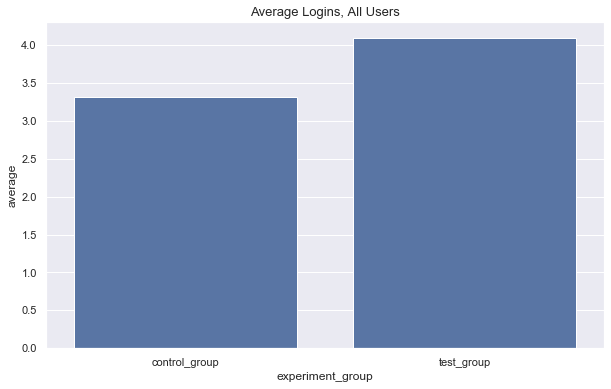

In [10]:
BarPlot(statistic_df, 'Average Logins, All Users')

__Metric 2: Average days engaged__

Secondly, I should take a look at whether users are engaging more into this app. Since there could be occation that users freqeuntly log in within the same day but also log out in quick session, causing the numbers of log in increase while the engagement days are flat. To make the hypothesis that the new feature did make a change more robust, I also compare users engagement on both groups.
- __null hypothesis__ : the number of users engagement days after experiment is __the same as__ before.
- __alternative hypothesis__ : the number of users engagement days after experiment is __significantly diffferent from__ the number before.

I will conduct similar process same as average logins.

In [11]:
sql = '''
WITH experiment AS (
    SELECT user_id, experiment, experiment_group, occurred_at
    FROM experiments
    WHERE experiment = 'publisher_update'
)
SELECT ex.experiment, ex.experiment_group, ex.occurred_at AS treatment_start,
       u.user_id, u.activated_at,
       COUNT(DISTINCT(strftime('%Y-%m-%d', e.occurred_at))) AS metric
FROM experiment ex
JOIN users u ON u.user_id = ex.user_id
JOIN events e ON e.user_id = ex.user_id
AND e.occurred_at >= ex.occurred_at
AND e.occurred_at < '2014-07-01'
AND e.event_type = 'engagement'
GROUP BY 1, 2, 3, 4, 5
'''
SQL = pysqldf(sql)
SQL.head()

,experiment,experiment_group,treatment_start,user_id,activated_at,metric
0,publisher_update,control_group,2014-06-01 01:02:31,597.0,2013-02-23 12:48:16,9
1,publisher_update,control_group,2014-06-01 04:16:34,13192.0,2014-05-28 04:15:19,5
2,publisher_update,control_group,2014-06-01 04:41:16,13184.0,2014-05-28 04:39:41,2
3,publisher_update,control_group,2014-06-01 06:26:50,3584.0,2013-08-28 16:45:31,4
4,publisher_update,control_group,2014-06-01 07:07:15,13088.0,2014-05-27 10:41:22,2


In [12]:
statistic_df = CalStat(SQL)
statistic_df

,experiment,experiment_group,count,average,sum,stdev,variance
0,publisher_update,control_group,1746,3.033792,5297,2.151964,4.630949
1,publisher_update,test_group,849,3.603062,3059,2.699413,7.286830


In [13]:
HypothesisTest(statistic_df)

T-statistic: 5.370681448295528
Degrees of Freedom: 1388.0
P_Value: 9.186157314622304e-08
Reject Null Hypothesis


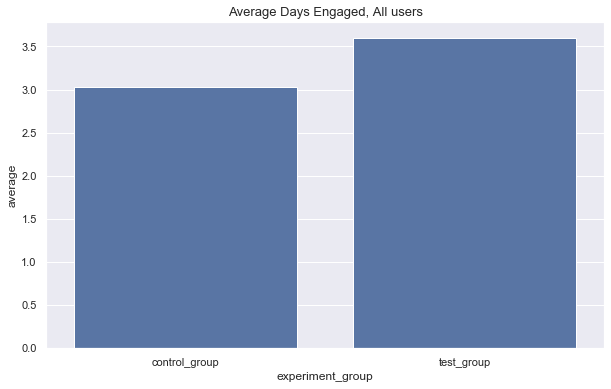

In [14]:
BarPlot(statistic_df, 'Average Days Engaged, All users')

To conclude, the average number of logins per user on the test group is significantly different from the control group, meaning that the users activity is more active after the change, they sign into Yammer more. Besides, the users' average days engaged in Yammer also significently different in experimental groups, meaning that users are logging in on more days as well. Since both metrics are up, it appears that the newly launch feature causing the change is not due to random chance, it's the sign that this feature attracts more user.

However, I also notice that the number of usersin each group is severely uneven - the user count in control group is around twice as the count in experiment group. This is be one of the issue of A/B test - the users were treated incorrectly. Ideally, users should be treated randomly from each group, and it's better to have both groups similar amount of samples.

#### 2.2.2 Existing Users vs New Users

After digging in deeper, since we're dealing with time series data, thus making our test imperfect and suffering from a dethodological error. That is, the test combines new users and existing users into the same group, and measures the number of messages they post during the testing window. To be more specific, users who signed up a day or two day before the test ended are considered as new users, however, they have much less time to post messages compared with old users. Therefore, it would make more sense to consider new and existing users separately. Not only does this make comparing magnitudes more appropriate, it also lets you test for novelty effects. For example, users familiar with Yammer might try out a new feature because it's new, temporarily boosting thier overall enagement; but the new feature are not novel to new users, so they are less likely to react to that difference.

Let's first take a look at the users description in general.

In [15]:
sql = '''
SELECT strftime('%Y-%m', u.activated_at) AS y_m_activated,
       COUNT(CASE WHEN ex.experiment_group = 'control_group' THEN u.user_id ELSE NULL END) AS control_users,
       COUNT(CASE WHEN ex.experiment_group = 'test_group' THEN u.user_id ELSE NULL END) AS experiment_users      
FROM experiments ex
JOIN users u ON ex.user_id = u.user_id
GROUP BY 1
ORDER BY 1
'''
SQL = pysqldf(sql)
SQL.tail()

,y_m_activated,control_users,experiment_users
13,2014-02,75,51
14,2014-03,81,60
15,2014-04,82,86
16,2014-05,182,203
17,2014-06,873,0


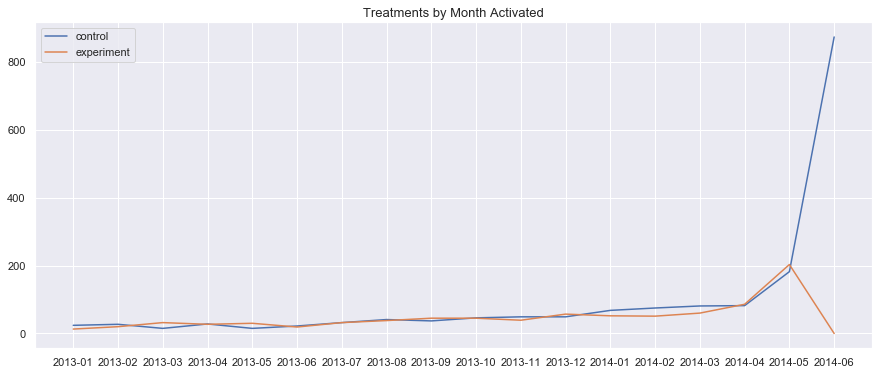

In [16]:
f, ax = plt.subplots(figsize = (15, 6))
plt.plot(SQL['y_m_activated'], SQL['control_users'], label = 'control')
plt.plot(SQL['y_m_activated'], SQL['experiment_users'], label = 'experiment')
plt.legend()
plt.title('Treatments by Month Activated', fontsize = 13)
plt.show()

As I've mentioned before, since new users have less time to engage the app, they would be expected to post less than existing users given their shorter exposure to Yammer. For those users in control group, they would tend to lower the overall posting rate within the group. To avoid this error, I would analyze the test in a way that ignores new users by only consider users activated one month prior to the date our test ended.

In [17]:
sql = '''
WITH experiment AS (
    SELECT user_id, experiment, experiment_group, occurred_at
    FROM experiments
    WHERE experiment = 'publisher_update'
)
SELECT a.experiment_group,
       COUNT(a.user_id) user_count
FROM( SELECT ex.experiment, 
             ex.experiment_group,
             ex.occurred_at AS treatment_start,
             u.user_id, 
             u.activated_at
      FROM experiment ex
      JOIN users u ON u.user_id = ex.user_id
      AND u.activated_at < '2014-06-01' 
      JOIN events e ON e.user_id = ex.user_id
      AND e.occurred_at >= ex.occurred_at
      AND e.occurred_at <= '2014-07-01'
      AND e.event_type = 'engagement'
      GROUP BY 1,2,3,4,5) a
GROUP BY 1
'''
SQL = pysqldf(sql)
SQL

,experiment_group,user_count
0,control_group,873
1,test_group,849


Now, by spliting the existed users and new users, I notice that the number of users between two groups are very close, indicating that we may have successfully split traffic to each group evenly. To confirm this, I can conduct sanity check which can check whether they are equivalent between the two groups. 

In [18]:
# sanity check
def get_z_score(alpha):
    return -norm.ppf(alpha/2)

cnt_users = statistic_df['count'][0]
total_users = statistic_df['count'][0] + statistic_df['count'][1]
ratio = cnt_users / total_users
prob = 0.5
alpha = 0.05
std_err = np.sqrt(prob * (1-prob) / total_users)
z_score = get_z_score(alpha)
margin_err = z_score * std_err
lower_bound = prob - margin_err
upper_bound = prob + margin_err
if (ratio > lower_bound) & (ratio < upper_bound):
    sanity_check = 'Pass'
else:
    sanity_check = 'Fail'
    
print('Control-Experiment Ratio:\t', ratio)
print('Confidence Interval:\t\t', '(', lower_bound, ', ', upper_bound, ')')
print('Sanity Check:\t\t\t', sanity_check)

Control-Experiment Ratio:	 0.6728323699421965
Confidence Interval:		 ( 0.48076246538600953 ,  0.5192375346139905 )
Sanity Check:			 Fail


Now we've passed the sanity checks, meaning that the sample user count is randomly split between two groups, then I can use the same testing hypothesis to observe the significance for metrics such as average messages sent, user logins etc.

__Metric 1: Average Messages Sent, by Existing Users__

In [19]:
sql = '''
WITH experiment AS (
    SELECT user_id, experiment, experiment_group, occurred_at
    FROM experiments
    WHERE experiment = 'publisher_update'
)
SELECT ex.experiment, 
       ex.experiment_group, 
       ex.occurred_at AS treatment_start,
       u.user_id, 
       u.activated_at,
       COUNT(CASE WHEN e.event_name = 'send_message' THEN e.user_id ELSE NULL END) AS metric
FROM experiment ex
JOIN users u ON u.user_id = ex.user_id
AND u.activated_at < '2014-06-01' 
JOIN events e ON e.user_id = ex.user_id
AND e.occurred_at >= ex.occurred_at
AND e.occurred_at <= '2014-07-01'
AND e.event_type = 'engagement'
GROUP BY 1, 2, 3, 4, 5
'''
SQL = pysqldf(sql)
SQL.head()

,experiment,experiment_group,treatment_start,user_id,activated_at,metric
0,publisher_update,control_group,2014-06-01 01:02:31,597.0,2013-02-23 12:48:16,10
1,publisher_update,control_group,2014-06-01 04:16:34,13192.0,2014-05-28 04:15:19,3
2,publisher_update,control_group,2014-06-01 04:41:16,13184.0,2014-05-28 04:39:41,0
3,publisher_update,control_group,2014-06-01 06:26:50,3584.0,2013-08-28 16:45:31,3
4,publisher_update,control_group,2014-06-01 07:07:15,13088.0,2014-05-27 10:41:22,1


In [20]:
statistic_df = CalStat(SQL)
statistic_df

,experiment,experiment_group,count,average,sum,stdev,variance
0,publisher_update,control_group,873,2.916380,2546,3.875780,15.021669
1,publisher_update,test_group,849,4.075383,3460,4.767616,22.730160


In [21]:
HypothesisTest(statistic_df)

T-statistic: 5.526595498221134
Degrees of Freedom: 1632.0
P_Value: 3.794571309982159e-08
Reject Null Hypothesis


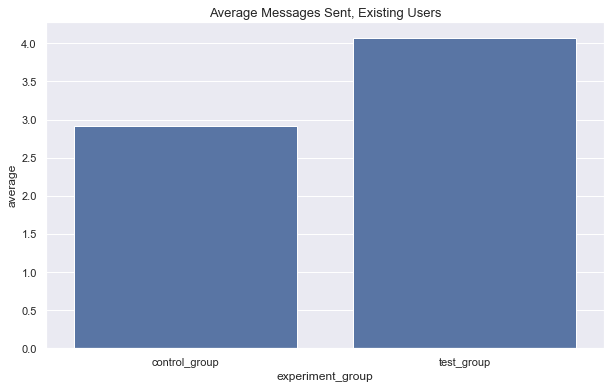

In [22]:
BarPlot(statistic_df, 'Average Messages Sent, Existing Users')

__Metric 2: Average Logins, by Existing Users__

In [23]:
sql = '''
WITH experiment AS (
    SELECT user_id, experiment, experiment_group, occurred_at
    FROM experiments
    WHERE experiment = 'publisher_update'
)
SELECT ex.experiment, ex.experiment_group, ex.occurred_at AS treatment_start,
       u.user_id, u.activated_at,
       COUNT(CASE WHEN e.event_name = 'login' THEN e.user_id ELSE NULL END) AS metric
FROM experiment ex
JOIN users u ON u.user_id = ex.user_id
AND u.activated_at < '2014-06-01' 
JOIN events e ON e.user_id = ex.user_id
AND e.occurred_at >= ex.occurred_at
AND e.occurred_at < '2014-07-01'
AND e.event_type = 'engagement'
GROUP BY 1, 2, 3, 4, 5
'''
SQL = pysqldf(sql)

In [24]:
statistic_df = CalStat(SQL)
statistic_df

,experiment,experiment_group,count,average,sum,stdev,variance
0,publisher_update,control_group,873,3.553265,3102,2.840519,8.068547
1,publisher_update,test_group,849,4.100118,3481,3.311018,10.962842


In [25]:
HypothesisTest(statistic_df)

T-statistic: 3.673965838812351
Degrees of Freedom: 1666.0
P_Value: 0.0002463673195654913
Reject Null Hypothesis


__Metric 3: Days Engaged for Existing Users, by Existing Users__

In [26]:
sql = '''
WITH experiment AS (
    SELECT user_id, experiment, experiment_group, occurred_at
    FROM experiments
    WHERE experiment = 'publisher_update'
)
SELECT ex.experiment, 
       ex.experiment_group,
       ex.occurred_at AS treatment_start,
       u.user_id, 
       u.activated_at,
       COUNT(DISTINCT(strftime('%Y-%m-%d', e.occurred_at))) AS metric
FROM experiment ex
JOIN users u ON u.user_id = ex.user_id
AND u.activated_at < '2014-06-01' 
JOIN events e ON e.user_id = ex.user_id
AND e.occurred_at >= ex.occurred_at
AND e.occurred_at < '2014-07-01'
AND e.event_type = 'engagement'
GROUP BY 1, 2, 3, 4, 5
'''
SQL = pysqldf(sql)

In [27]:
statistic_df = CalStat(SQL)
statistic_df

,experiment,experiment_group,count,average,sum,stdev,variance
0,publisher_update,control_group,873,3.183276,2779,2.335573,5.454903
1,publisher_update,test_group,849,3.603062,3059,2.699413,7.286830


In [28]:
HypothesisTest(statistic_df)

T-statistic: 3.446980063532932
Degrees of Freedom: 1670.0
P_Value: 0.0005809458357772893
Reject Null Hypothesis


Overall, after testing average logins, days engagement and average message sent again with only the existing users, the test results are still strong. This indicates that indroducing this new features to customers could bring more users' interactions within the app.

#### 2.1.3 Device

Given the above result, I would still only take those old users into my next analysis. Now, I focus on analyzing device differences across control and experiment group. I will first creating another column that identify the device type, then conduct testing on average logins to investigate that whether all three types of device have increment on users activities.

__Average Logins, by Device__

In [29]:
sql = '''
WITH event AS(
    SELECT *,
           CASE WHEN device IN ('amazon fire phone', 'nexus 10', 'iphone 5', 'nexus 7', 'iphone 5s', 'nexus 5', 'htc one', 'iphone 4s', 'samsung galaxy note', 'nokia lumia 635', 'samsung galaxy s4') THEN 'mobile'
                WHEN device IN ('ipad mini', 'samsung galaxy tablet', 'kindle fire', 'ipad air') THEN 'tablet'
                WHEN device IN ('dell inspiron desktop', 'macbook pro', 'asus chromebook', 'windows surface', 'macbook air', 'lenovo thinkpad', 'mac mini', 'acer aspire desktop', 'acer aspire notebook', 'dell inspiron notebook', 'hp pavilion desktop') THEN 'computer'
                ELSE null END AS platform
    FROM events
)
SELECT ex.experiment, 
       ex.experiment_group,
       ex.occurred_at AS treatment_start,
       u.user_id, 
       u.activated_at,
       e.platform,
       COUNT(CASE WHEN e.event_name = 'login' THEN e.user_id ELSE NULL END) AS metric
FROM experiments ex
JOIN users u ON u.user_id = ex.user_id
AND u.activated_at < '2014-06-01' 
JOIN event e ON e.user_id = ex.user_id
AND e.occurred_at >= ex.occurred_at
AND e.occurred_at < '2014-07-01'
AND e.event_type = 'engagement'
GROUP BY 1, 2, 3, 4, 5
'''
SQL = pysqldf(sql)
SQL.head()

,experiment,experiment_group,treatment_start,user_id,activated_at,platform,metric
0,publisher_update,control_group,2014-06-01 01:02:31,597.0,2013-02-23 12:48:16,mobile,11
1,publisher_update,control_group,2014-06-01 04:16:34,13192.0,2014-05-28 04:15:19,computer,5
2,publisher_update,control_group,2014-06-01 04:41:16,13184.0,2014-05-28 04:39:41,computer,2
3,publisher_update,control_group,2014-06-01 06:26:50,3584.0,2013-08-28 16:45:31,tablet,4
4,publisher_update,control_group,2014-06-01 07:07:15,13088.0,2014-05-27 10:41:22,computer,2


In [30]:
grouping = pd.DataFrame(SQL.groupby(['platform', 'experiment_group'])['metric'].agg([('average', 'mean'), ('stdev', np.std), ('variance', np.var), ('count', 'size')]))
grouping

average     stdev   variance  count
platform experiment_group                                      
computer control_group     3.602000  2.724416   7.422441    500
         test_group        4.160677  3.440717  11.838535    473
mobile   control_group     3.525806  3.047251   9.285740    310
         test_group        4.065015  3.166024  10.023710    323
tablet   control_group     3.338710  2.721761   7.407985     62
         test_group        3.510638  2.765253   7.646623     47

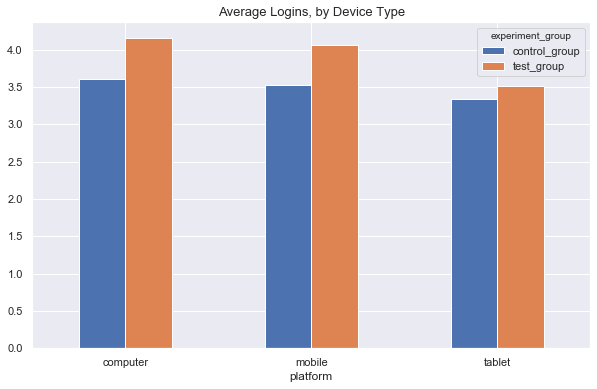

In [31]:
grouping['average'].unstack().plot(kind = 'bar', figsize = (10, 6))
plt.xticks(rotation = 'horizontal')
plt.title('Average Logins, by Device Type', fontsize = 13)
plt.show()

Now, I found that among three types of devices, `computer` and `mobile` have obvious increment while `tablet` only has small amount of increase, not very obvious. To confirm that whether these three rises are not due to random chance, I will conduct hypothesis testing to three devices across two groups seperately.

In [32]:
computer = grouping.loc['computer'].reset_index()
mobile = grouping.loc['mobile'].reset_index()
tablet = grouping.loc['tablet'].reset_index()

In [33]:
print('For Computer: ')
HypothesisTest(computer)

print('\nFor Mobile: ')
HypothesisTest(computer)

print('\nFor Tablet: ')
HypothesisTest(tablet)

For Computer: 
T-statistic: 2.797810300308778
Degrees of Freedom: 898.0
P_Value: 0.005255109802487075
Reject Null Hypothesis

For Mobile: 
T-statistic: 2.797810300308778
Degrees of Freedom: 898.0
P_Value: 0.005255109802487075
Reject Null Hypothesis

For Tablet: 
T-statistic: 0.3236583352762302
Degrees of Freedom: 98.0
P_Value: 0.7468864037542629
Accepct Null Hypothesis


Just as what I expected, only computer and mobile have more logins activity while the number of tablet logins remains unchanged. This indicate that the new feature only has positive impact to customers use device like computer or mobile.


## 3 Conclusion

This analysis begins by investigating user logins and engagements using A/B testing to observe whether launching a new feature could increase users' interaction with the app. I started by analyze average longins and average days engaged and found that the experiment group has huge improvement of users interactions compared with control group. But I also notice that the traffics diversed to each group are uneven, meaning that there are over double amount of users being distributed to control group. Since running the A/B test should be caucious about the number of sample of each group, I chose to select users that activate their Yammer account over a month before the test ended data, thus those new users who might lower the activities on the control group are ruled out. I conducted a sanity check before tests to make sure the traffic is distributed evenly. After observing the metrics - average longins , average days engaged and average message sent, the changes were still obvious. Finally, I added another cohort of users - splitting users by their device types - to figure out if the impact works for all kinds of device users. But quite the opposite, only the computer and mobile users react to this new change.

To conclude, I would suggest launching the new feature since its reactions on experiment are generally good. But at the same time, I would also work with technical team to figure out the tablet version to see why users of tablet don't have much improvement, is it due to broken feature/button on the tablet version?

To further improve this analysis, I can also add another group of users by dividing them according to the user types, maybe different types of users, like users from different industries or job occupations might impact their preferences towards the features within the application.

